In [1]:
import pandas as pd
import numpy as np
import theano
from sklearn import preprocessing
df = pd.read_csv('rossmann.csv')
df = df.set_index('Unnamed: 0')
df.head()

/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
Unnamed: 0,,,,,,,,,,,,,,,,,,
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [2]:
df = pd.concat([df, pd.get_dummies(df['StoreType'])], axis=1)
df = pd.concat([df, pd.get_dummies(df['DayOfWeek'])], axis=1)
df = df.drop(['Date', 'DayOfWeek', 'StoreType', 'Assortment', 'StateHoliday', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'], axis=1)
df['Sales'] = df['Sales'].astype(theano.config.floatX)
print(df.columns)
print(len(df.columns))

Index([        'Store',         'Sales',     'Customers',          'Open',
               'Promo', 'SchoolHoliday',        'Promo2',             'a',
                   'b',             'c',             'd',               1,
                     2,               3,               4,               5,
                     6,               7],
      dtype='object')
18


In [3]:
store_names = df.Store.unique()
n_stores = len(df.Store.unique())
n_stores

1115

In [4]:
df.shape

(1017209, 18)

In [5]:
df['store_idx'] = df['Store']-1

In [6]:
df = df.loc[df['Open']==1].drop(['Open'],axis=1)
df['Sales'] = np.log(df['Sales'])
df = df.replace([np.inf, -np.inf, np.nan], 0)
print(df.Sales)

Unnamed: 0
0          8.568456
1          8.710125
2          9.025696
3          9.546455
4          8.480944
             ...   
1016776    8.124151
1016827    9.284055
1016863    8.524169
1017042    8.409831
1017190    8.692994
Name: Sales, Length: 844392, dtype: float64


In [7]:
scaler = preprocessing.StandardScaler()
df[['Customers']] = scaler.fit_transform(df[['Customers']].to_numpy())
df

,Store,Sales,Customers,Promo,SchoolHoliday,Promo2,a,b,c,d,1,2,3,4,5,6,7,store_idx
Unnamed: 0,,,,,,,,,,,,,,,,,,
0,1,8.568456,-0.517732,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0
1,2,8.710125,-0.343268,1,1,1,1,0,0,0,0,0,0,0,1,0,0,1
2,3,9.025696,0.145233,1,1,1,1,0,0,0,0,0,0,0,1,0,0,2
3,4,9.546455,1.832556,1,1,0,0,0,1,0,0,0,0,0,1,0,0,3
4,5,8.480944,-0.507763,1,1,0,1,0,0,0,0,0,0,0,1,0,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,8.124151,-0.490316,0,1,0,0,1,0,0,0,1,0,0,0,0,0,681
1016827,733,9.284055,4.023333,0,1,0,0,1,0,0,0,1,0,0,0,0,0,732
1016863,769,8.524169,1.209468,0,1,1,0,1,0,0,0,1,0,0,0,0,0,768


In [8]:
len(df.columns)

18

In [9]:
from statistics import mean
mean(df['Sales'])

8.757004155158869

In [10]:
df_train = df.iloc[:700000,:]
df_test = df.iloc[700001:,:]

In [11]:
import pymc3 as pm
with pm.Model() as hierarchical_model2:
    # Hyperpriors for group nodes
    store_idx = df_train.store_idx.values
    
    mu_a = pm.Normal('mu_a_', mu=8.757, sigma=10)
    sigma_a = pm.HalfNormal('sigma_a_', 5.)
    
    mu_b = []
    sigma_b = []
    
    for x in range(15):
        mu_b.append(pm.Normal('mu_b_'+str(x), mu=0., sigma=10))
        sigma_b.append(pm.HalfNormal('sigma_b_'+str(x), 5.))

    a = pm.Normal('a_', mu=mu_a, sigma=sigma_a, shape=n_stores)
    # Intercept for each county, distributed around group mean mu_a
    b = []
    for x in range(15):
        b1 = pm.Normal('b_'+str(x), mu=mu_b[x], sigma=sigma_b[x], shape=n_stores)
        b.append(b1)

    # Model error
    eps = pm.HalfCauchy('eps_', 5.)

    radon_est = a[store_idx] 
    
    for x in range(15):
        print(df_train.columns[x+2])
        radon_est = radon_est + b[x][store_idx]*df_train.iloc[:,x+1].values

    # Data likelihood
    sales_like = pm.Normal('sales_like_', mu=radon_est, sigma=eps, observed=df_train.Sales)

Customers
Promo
SchoolHoliday
Promo2
a
b
c
d
1
2
3
4
5
6
7


In [12]:
# Inference button (TM)!
with hierarchical_model2:
    hierarchical_trace2 = pm.sample(20, chains=2, tune=20, target_accept=.9)

Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [eps_, b_14, b_13, b_12, b_11, b_10, b_9, b_8, b_7, b_6, b_5, b_4, b_3, b_2, b_1, b_0, a_, sigma_b_14, mu_b_14, sigma_b_13, mu_b_13, sigma_b_12, mu_b_12, sigma_b_11, mu_b_11, sigma_b_10, mu_b_10, sigma_b_9, mu_b_9, sigma_b_8, mu_b_8, sigma_b_7, mu_b_7, sigma_b_6, mu_b_6, sigma_b_5, mu_b_5, sigma_b_4, mu_b_4, sigma_b_3, mu_b_3, sigma_b_2, mu_b_2, sigma_b_1, mu_b_1, sigma_b_0, mu_b_0, sigma_a_, mu_a_]


Sampling 2 chains for 20 tune and 20 draw iterations (40 + 40 draws total) took 17028 seconds.
/opt/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:603: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.


/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/anaconda3/lib/python3.7/site-packages/arviz/plots/traceplot.py:254: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (33), generating only 20 plots
  UserWarning,


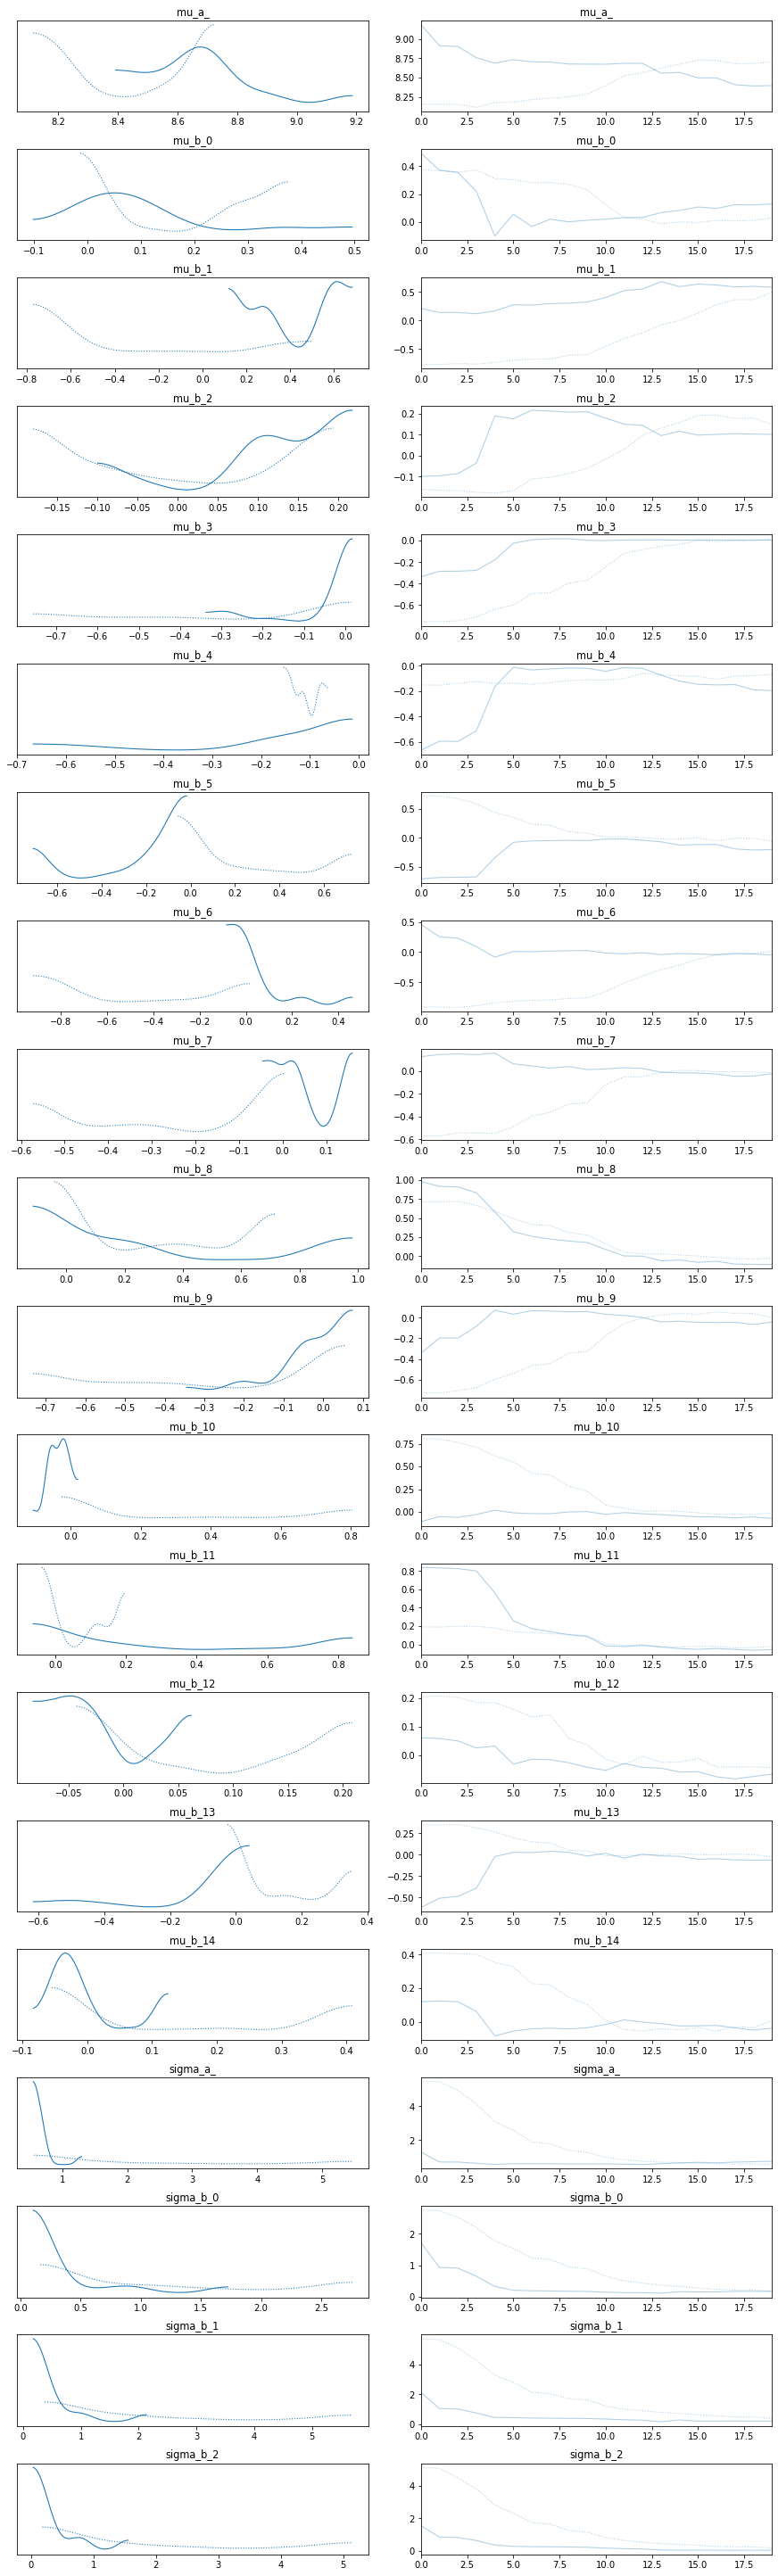

In [13]:
pm.traceplot(hierarchical_trace2,
             var_names=['mu_a_', 'mu_b_0', 'mu_b_1', 'mu_b_2', 'mu_b_3', 'mu_b_4', 'mu_b_5', 'mu_b_6',
                   'mu_b_7', 'mu_b_8', 'mu_b_9', 'mu_b_10', 'mu_b_11', 'mu_b_12', 'mu_b_13','mu_b_14',
                        'sigma_a_', 'sigma_b_0', 'sigma_b_1', 'sigma_b_2', 'sigma_b_3', 
                        'sigma_b_4', 'sigma_b_5', 'sigma_b_6', 'sigma_b_7', 'sigma_b_8', 'sigma_b_9',
                   'sigma_b_10', 'sigma_b_11', 'sigma_b_12', 'sigma_b_13', 'sigma_b_14',
                        'eps_', ]);

/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


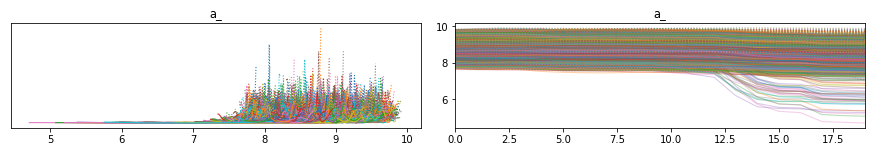

In [14]:
pm.traceplot(hierarchical_trace2,
             var_names=['a_']);

In [15]:
import arviz as az
with hierarchical_model2:
    ppc2 = pm.sample_posterior_predictive(
        hierarchical_trace2, 
        var_names=['a_', 'b_0', 'b_1', 'b_2', 'b_3', 'b_4', 'b_5', 'b_6',
                   'b_7', 'b_8', 'b_9', 'b_10', 'b_11', 'b_12', 'b_13','b_14',
                    'sales_like_'], 
        random_seed=3
    )

/opt/anaconda3/lib/python3.7/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


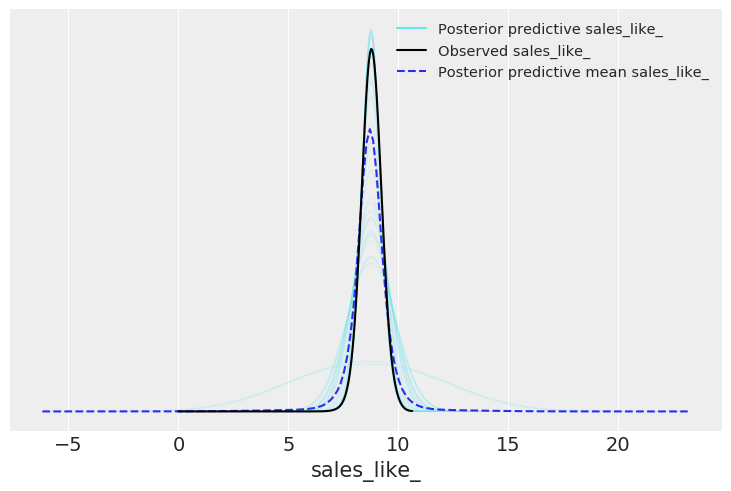

In [16]:
az.style.use("arviz-darkgrid")
idata2 = az.from_pymc3(hierarchical_trace2, posterior_predictive=ppc2)
az.plot_ppc(idata2);

In [17]:
ppc2['sales_like_'].shape

(40, 700000)

In [23]:
sales_predict = ppc2['sales_like_'].T
sales_predict.shape

(700000, 40)

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
sales_predict_mean = sales_predict.mean(axis=1)
sales_predict_mean.shape

(700000,)

In [20]:
np.sqrt(mean_squared_error(np.exp(df_train.Sales), np.exp(sales_predict_mean)))

2106.0429048763945

In [28]:
print(r2_score(np.exp(df_train.Sales), np.exp(sales_predict_mean)))

0.5439793792479386


In [21]:
alpha_pred = ppc2['a_'].mean()
betas_pred = []
for i in range(15):
    betas_pred.append(ppc2['b_'+str(i)].mean())
y_pred = alpha_pred + np.dot(betas_pred, df_test.iloc[:,2:-1].T)

In [27]:
print(np.sqrt(mean_squared_error(np.exp(df_test.Sales), np.exp(y_pred))))
print(r2_score(np.exp(df_test.Sales), np.exp(y_pred)))

2721.1581827530476
0.18962157792565304
